# Extended analysis of the network embeddings

This notebook aims to assess individual network embeddings and compare those with respect to their structure.

---

## 0. Environmental setup

First, we load required packages.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import sys

from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import pdist

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sys.path.append("../../../")

from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file

---

## 1. Read in data

Second, we read in two different network embeddings into memory. Those embeddings were inferred training a GAE on the task of reconstructing the adjacency matrix alongside with single gene expression data. The setup of the two models and the training is comparable with the only difference being the number of hidden dimension and latent dimension of the graph-convolutional encoder and decoder set to 128, respectively 1024.

In [2]:
embs_128 = pd.read_csv("../../../data/ppi/embedding/node_embeddings_cv.csv", index_col = 0)
embs_1024 = pd.read_csv("../../../data/ppi/embedding/node_embeddings_cv_1024.csv", index_col = 0)

Additionally, we load a number of gene set information.

In [3]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results_cv.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/h.all.v7.4.symbols.gmt"
)

---

## 2. Analysis

### 2.1. Visualization of the embedding spaces

As a first step, we visualize the inferred latent spaces using corresponding TSNE plots.

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


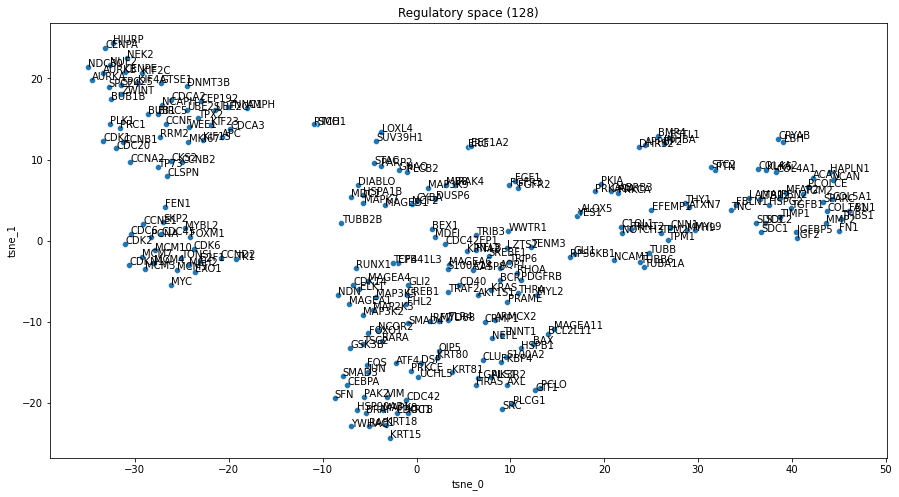

In [4]:
fig, ax = plt.subplots(figsize=[15,8])
ax=plot_tsne_embs(embs_128, ax=ax)
ax.set_title("Regulatory space (128)")
plt.show()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


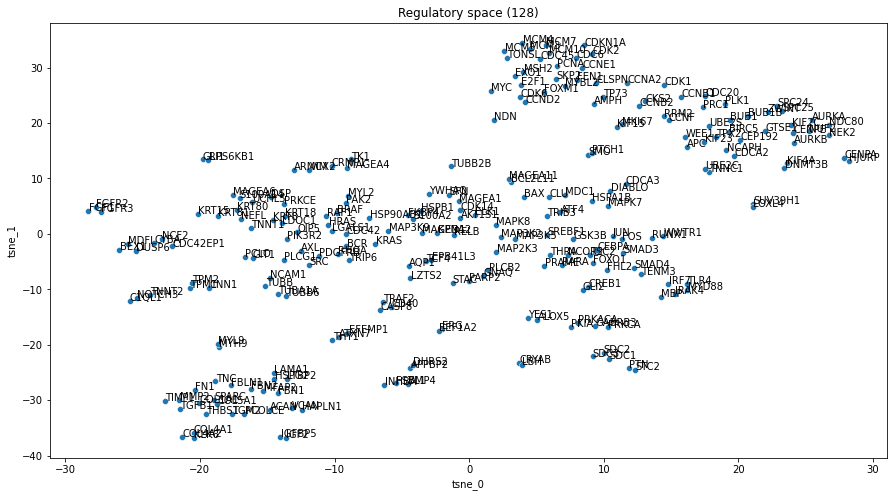

In [5]:
fig, ax = plt.subplots(figsize=[15,8])
ax=plot_tsne_embs(embs_1024, ax=ax)
ax.set_title("Regulatory space (128)")
plt.show()

Visually both embeddings show three major clusters in TSNE space which also seem to have similar structure. We will quantify that in the following using hierarchical co-clustering analyses.

----



### 2.1. Co-cluster analysis

To assess how much structure is shared between the two embeddings, we will cluster both latent spaces hierarchically using average linkage and euclidean/cosine distances. For a varying number of clusters, we will compute the adjusted mutual information to quantify the strength of the co-clustering.

In [31]:
ami_embs_avg = compute_ami_matrix(
    embs_128.loc[embs_128.index],
    embs_1024.loc[embs_128.index],
    affinity=["euclidean", "euclidean"],
    linkage="average",
)

ami_embs_cp = compute_ami_matrix(
    embs_128.loc[embs_128.index],
    embs_1024.loc[embs_128.index],
    affinity=["euclidean", "euclidean"],
    linkage="complete",
)

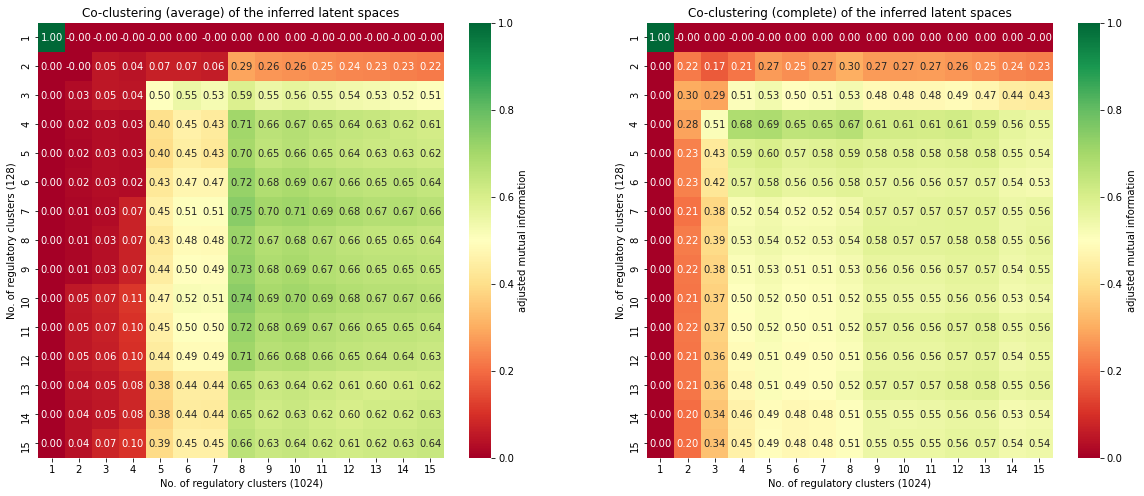

In [35]:
fig, ax = plt.subplots(figsize=[20, 8], ncols = 2)
ax = ax.flatten()
ax[0] = sns.heatmap(
    ami_embs_avg,
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax[0],
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax[0].set_xticklabels([i + 1 for i in range(15)])
ax[0].set_yticklabels([i + 1 for i in range(15)])
ax[0].set_xlabel("No. of regulatory clusters (1024)")
ax[0].set_ylabel("No. of regulatory clusters (128)")
ax[0].set_title("Co-clustering (average) of the inferred latent spaces")

ax[1] = sns.heatmap(
    ami_embs_cp,
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax[1],
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax[1].set_xticklabels([i + 1 for i in range(15)])
ax[1].set_yticklabels([i + 1 for i in range(15)])
ax[1].set_xlabel("No. of regulatory clusters (1024)")
ax[1].set_ylabel("No. of regulatory clusters (128)")
ax[1].set_title("Co-clustering (complete) of the inferred latent spaces")
plt.show()

The above plots indicate a non-random co-clustering especially for increasing number of clusters. However, it is important to mention that the adjusted mutual information is biased and tends to increase with larger number of clusters. Nonetheless, there are signficant differences between the two cluster solutions.

To further visualize the co-clustering we plot the dendograms for the clustering below. Note that we vary between average and complete linkage.

#### Average linkage

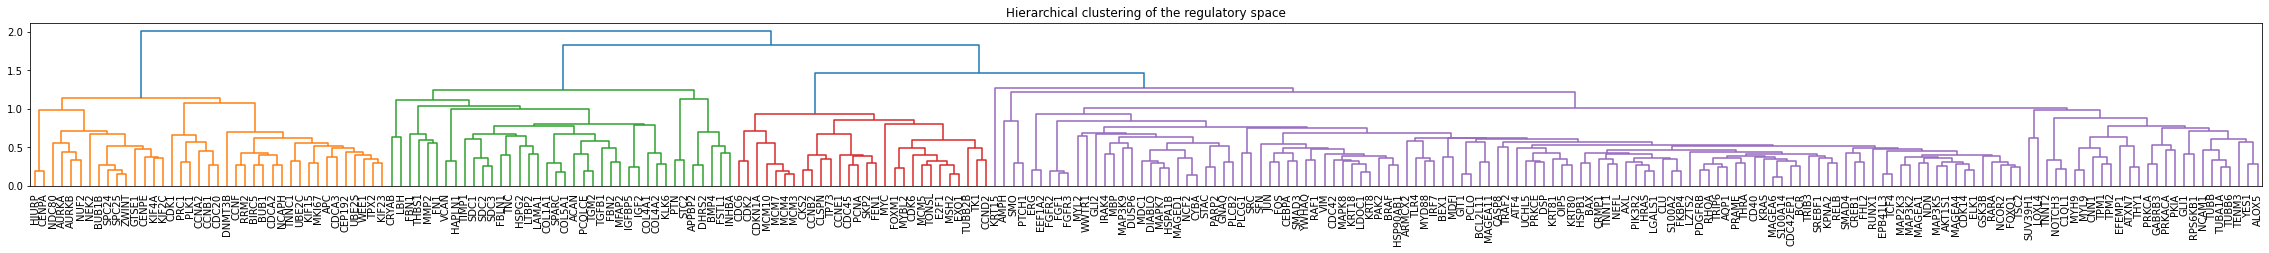

In [16]:
plt.figure(figsize=[40, 3])
corr_condensed = pdist(embs_128)
z = hc.linkage(corr_condensed, method="average")
dendrogram = hc.dendrogram(
    z, labels=embs_128.index, leaf_font_size=10
)
plt.title("Hierarchical clustering of the regulatory space (128)")
plt.show()

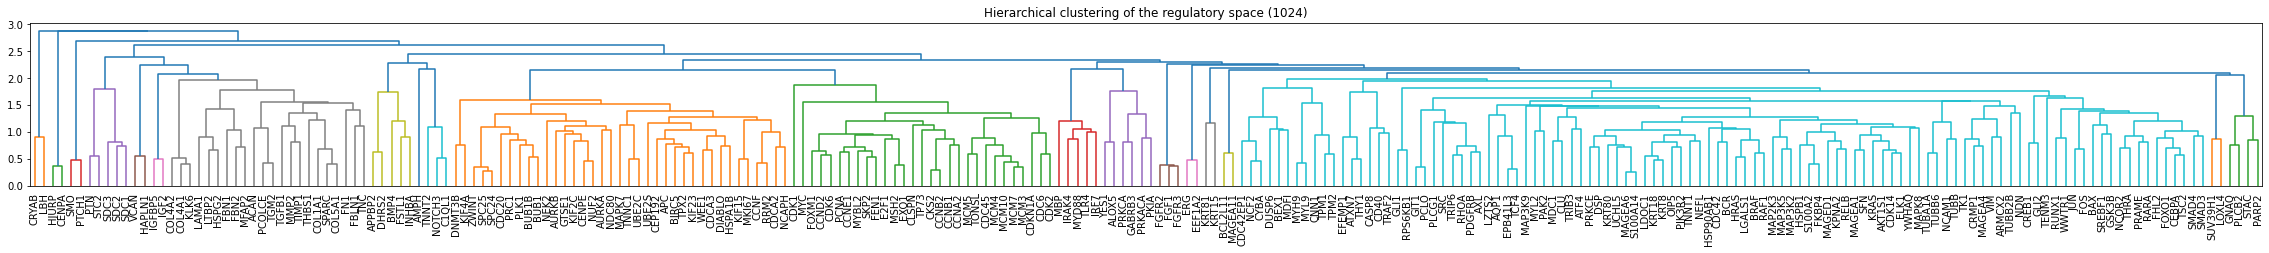

In [18]:
plt.figure(figsize=[40, 3])
corr_condensed = pdist(embs_1024)
z = hc.linkage(corr_condensed, method="average")
dendrogram = hc.dendrogram(
    z, labels=embs_1024.index, leaf_font_size=10
)
plt.title("Hierarchical clustering of the regulatory space (1024)")
plt.show()

#### Complete linkage

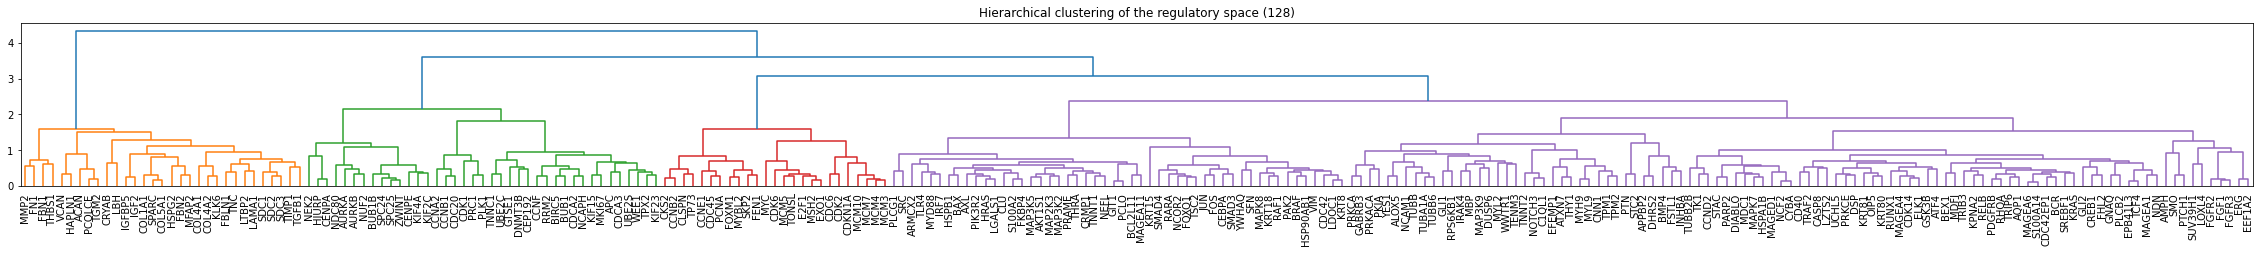

In [33]:
plt.figure(figsize=[40, 3])
corr_condensed = pdist(embs_128)
z = hc.linkage(corr_condensed, method="complete")
dendrogram = hc.dendrogram(
    z, labels=embs_128.index, leaf_font_size=10
)
plt.title("Hierarchical clustering of the regulatory space (128)")
plt.show()

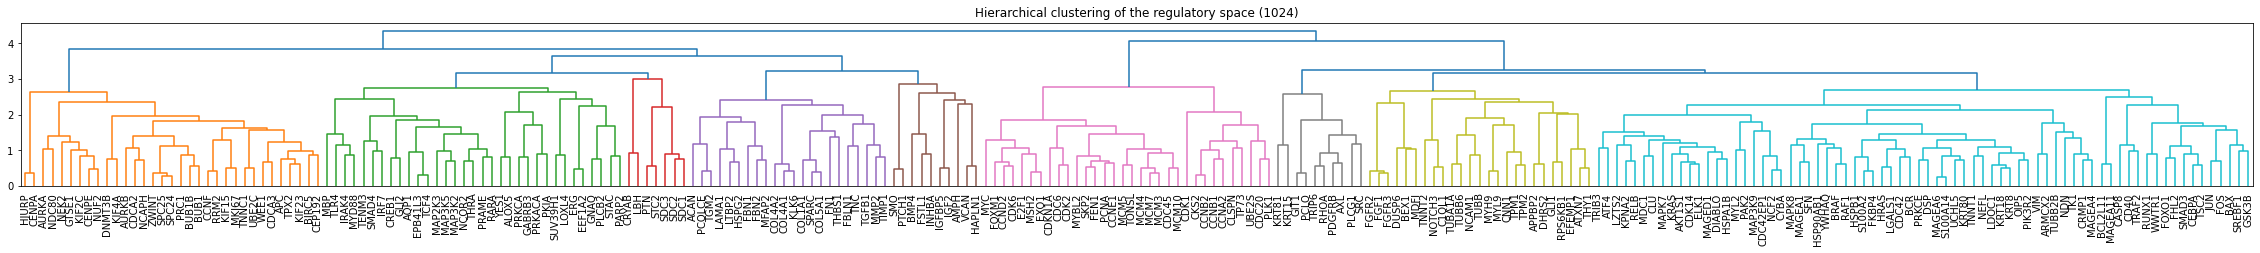

In [34]:
plt.figure(figsize=[40, 3])
corr_condensed = pdist(embs_1024)
z = hc.linkage(corr_condensed, method="complete")
dendrogram = hc.dendrogram(
    z, labels=embs_1024.index, leaf_font_size=10
)
plt.title("Hierarchical clustering of the regulatory space (1024)")
plt.show()

---

### 2.2. Rank analysis

Next, we aim to assess the rank of the inferred latent spaces and compare those between the two solutions. We also assess the change of the ranks upon leaving out single genes in order to quantify their contribution to the rank of the inferred space.

Contrary to our expectations, the inferred solutions are not low rank. To complement the analysis, we will also assess the number of components required to explain 90% of the variance for yet another indication of the rank of the inferred spaces.

#### 2.2.a. 128-dimensional embedding space

In [85]:
u, s, vh = np.linalg.svd(embs_128)

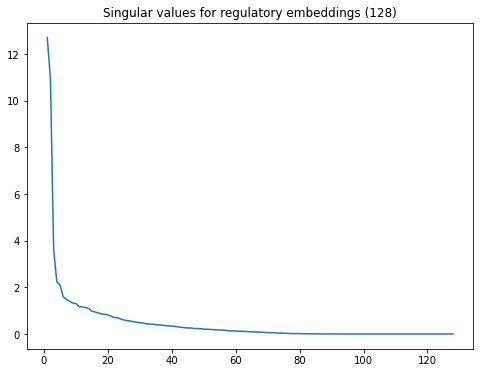

In [27]:
fig, ax = plt.subplots(figsize=[8,6])
ax.plot(np.arange(len(s))+1, s )
ax.set_title("Singular values for regulatory embeddings (128)")
plt.show()

The plot indicates that the matrix is fairly high rank as e.g. 90 singular values are greater than 1e-5.

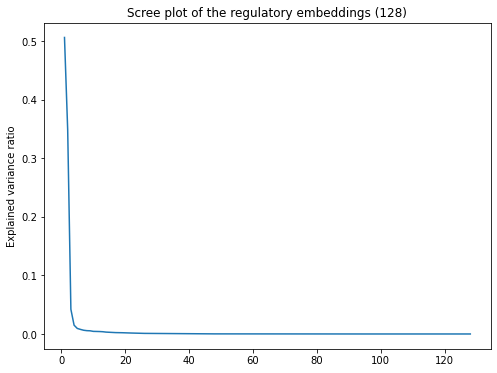

In [40]:
pca = PCA(n_components = 128).fit(embs_128)
fig, ax = plt.subplots(figsize=[8,6])
ax.plot(np.arange(128)+1, pca.explained_variance_ratio_)
ax.set_title("Scree plot of the regulatory embeddings (128)")
ax.set_ylabel("Explained variance ratio")
plt.show()

We see that the top 10 principal components explain a little more than 95% of the total variance of the data.

In [51]:
np.linalg.matrix_rank(embs_128)

128

In [82]:
delta_ranks_128 = get_rank_difference_dict(embs_128, tol=1e-1)
delta_ranks_128

{'CDCA2': 1, 'CASP8': 1, 'CEP192': 1, 'NCAM1': 1, 'NEK2': 1}

#### 2.2.b. 1024-dimensional embedding space

In [31]:
u, s, vh = np.linalg.svd(embs_1024)

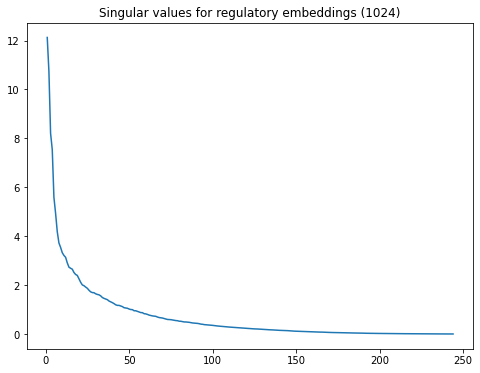

In [33]:
fig, ax = plt.subplots(figsize=[8,6])
ax.plot(np.arange(len(s))+1, s )
ax.set_title("Singular values for regulatory embeddings (1024)")
plt.show()

We find that the higher dimensional solution is not of lower rank but actually higher rank with 243 singular values taking values greater than 1e-5.

In [52]:
np.linalg.matrix_rank(embs_1024)

244

In [37]:
delta_ranks_128 = get_rank_difference_dict(embs_1024, tol=1e-8)
delta_ranks_128

{'CDCA2': 1,
 'APPBP2': 1,
 'TK1': 1,
 'MMP2': 1,
 'PRKACA': 1,
 'CDC45': 1,
 'NOTCH3': 1,
 'SPARC': 1,
 'FBN1': 1,
 'FBLN1': 1,
 'RUNX1': 1,
 'SREBF1': 1,
 'STAC': 1,
 'TNNT1': 1,
 'GTSE1': 1,
 'TNNC1': 1,
 'YWHAQ': 1,
 'ERG': 1,
 'BIRC5': 1,
 'PRKCA': 1,
 'ACAN': 1,
 'CASP8': 1,
 'LZTS2': 1,
 'SPC25': 1,
 'MAPK7': 1,
 'S100A2': 1,
 'TUBB2B': 1,
 'CDC6': 1,
 'DHRS2': 1,
 'CEBPA': 1,
 'BEX1': 1,
 'UCHL5': 1,
 'HSPB1': 1,
 'WEE1': 1,
 'BMP4': 1,
 'PRAME': 1,
 'MYL2': 1,
 'SUV39H1': 1,
 'SDC2': 1,
 'TNC': 1,
 'DIABLO': 1,
 'DNMT3B': 1,
 'APC': 1,
 'TPM1': 1,
 'FKBP4': 1,
 'MAGEA6': 1,
 'LTBP2': 1,
 'CNN1': 1,
 'CLSPN': 1,
 'CRMP1': 1,
 'MCM4': 1,
 'GLI1': 1,
 'PKIA': 1,
 'CDKN1A': 1,
 'COL4A2': 1,
 'MAGEA1': 1,
 'MCM5': 1,
 'CDC42EP1': 1,
 'PCNA': 1,
 'JUN': 1,
 'NCF2': 1,
 'FOS': 1,
 'CD40': 1,
 'MAGED1': 1,
 'FBN2': 1,
 'MAP2K3': 1,
 'YES1': 1,
 'CDCA3': 1,
 'BCL2L11': 1,
 'AURKA': 1,
 'CCND2': 1,
 'MAP3K5': 1,
 'PRC1': 1,
 'TP73': 1,
 'CYBA': 1,
 'CDK14': 1,
 'TIMP1': 1,
 'TLR4': 1,
 

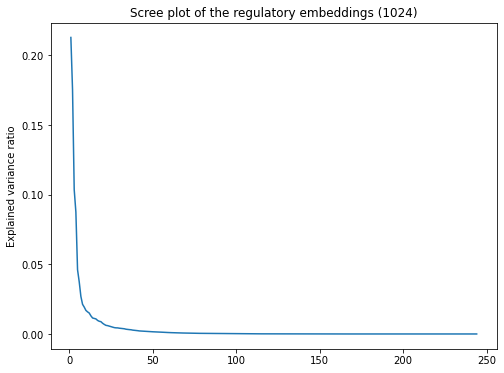

In [38]:
pca = PCA(n_components = 244).fit(embs_1024)
fig, ax = plt.subplots(figsize=[8,6])
ax.plot(np.arange(244)+1, pca.explained_variance_ratio_)
ax.set_title("Scree plot of the regulatory embeddings (1024)")
ax.set_ylabel("Explained variance ratio")
plt.show()

We see that the top 43 principal components explain a little more than 95% of the total variance of the data.

Jointly the above analysis indicate that while we would have expected inferred embeddings to be low rank. That does not hold true.

---